In [1]:
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from torch_geometric.utils import to_networkx, negative_sampling, to_dense_adj
from torch_geometric.datasets import KarateClub

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
data = KarateClub()[0]

In [3]:
data

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])

In [5]:
data.edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

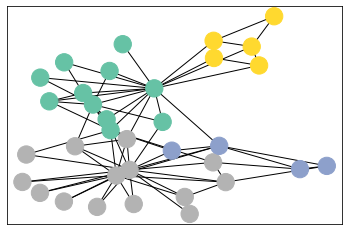

In [4]:
G = to_networkx(data, to_undirected=True)

nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,node_color=data.y, cmap="Set2")

In [10]:
class DataOption1(Dataset):
    
    def __init__(self, edge_index):
        
        Adj = to_dense_adj(data.edge_index).numpy().squeeze()
        
        pos_samples = torch.LongTensor(
            np.argwhere(Adj == 1)
        ) # positives [num_pos, 2]
        
        neg_samples = torch.LongTensor(
            np.argwhere((Adj + np.eye(len(Adj))) == 0)
        ) # negatives [num_neg, 2]
        
        label_pos = torch.ones(len(pos_samples)) # label 1 for positives
        label_neg = torch.zeros(len(neg_samples)) # label 0 for negatives
        
        print(f'num_pos={len(pos_samples)}\t num_neg={len(neg_samples)}')
        
        self.X = torch.cat([pos_samples, neg_samples]) # all samples
        self.y = torch.cat([label_pos, label_neg]) # all labels
        
    def __len__(self): return len(self.X)
    
    def __getitem__(self, idx):
        
        return self.X[idx, 0], self.X[idx, 1], self.y[idx]

In [11]:
class DataOption2(Dataset):
    
    def __init__(self, edge_index):
        
        pos_samples = edge_index # positives
        neg_samples = negative_sampling(edge_index, force_undirected=True, num_neg_samples=10000) # negatives
        
        pos_samples = pos_samples.transpose(0, 1)
        neg_samples = neg_samples.transpose(0, 1)
        
        print(f'num_pos={len(pos_samples)}\t num_neg={len(neg_samples)}')
                
        label_pos = torch.ones(len(pos_samples)) # label 1 for positives
        label_neg = torch.zeros(len(neg_samples)) # label 0 for negatives
        
        self.X = torch.cat([pos_samples, neg_samples]) # all samples
        self.y = torch.cat([label_pos, label_neg]) # all labels
        
    def __len__(self): return len(self.X)
    
    def __getitem__(self, idx):
        
        return self.X[idx, 0], self.X[idx, 1], self.y[idx]

In [12]:
# from torch_cluster import random_walk
# random_walk(data.edge_index[0, :], data.edge_index[1, :], start=torch.LongTensor([0, 1]), walk_length=5)

In [17]:
# dataloader

graph_data = DataOption1(data.edge_index)

train_loader = DataLoader(graph_data, batch_size=512, shuffle=True, num_workers=5)

num_pos=156	 num_neg=966


### model

In [18]:
class ShallowTrainer(nn.Module):
    
    def __init__(self, num_nodes, embedding_dim):
        
        super().__init__()
        
        self.encoder = nn.Embedding(num_nodes, embedding_dim)
        
    def get_embeddings(self):
        
        return self.encoder.weight.data # [num_nodes, emb_dim]
    
    def encode(self, u):
        
        """embedding lookup encoder"""
        
        return self.encoder(u)
    
    def decode(self, z_u, z_v):
        
        """ dot product decoder """
        
        return (z_u * z_v).sum(1) # [batch_size,1]
    
    def compute_loss(self, u, v, sim):
        
        """Binary cross-entropy loss"""
        
        # encoder pairs
        z_u = self.encode(u)
        z_v = self.encode(v)
        
        # decode with dot product
        pred_sim = self.decode(z_u, z_v)
        pred_sim = torch.sigmoid(pred_sim)
        
        # binary cross-entropy (mse loss should work aswell)
        loss = F.binary_cross_entropy(pred_sim, sim)
        
        return loss
    
    def visualize(self):
        
        """visulize embeddings with PCA"""
    
        node_embeddings = self.get_embeddings()

        node_cmp = PCA(n_components=2).fit_transform(node_embeddings)

        y = data.y.numpy()

        plt.scatter(node_cmp[:, 0], node_cmp[:, 1], s=140, c=y, cmap="Set2")

        plt.show()
    
    def train_model(self, dataloader, n_epochs, opt):
        
        """train model given dataloader, n_epochs and opt"""
                        
        for i in tqdm(range(n_epochs)):
        
            for u, v, sim in dataloader:

                loss = self.compute_loss(u, v, sim)

                loss.backward()

                opt.step()
                
                opt.zero_grad()
            
            if i % 100 == 0:
                
                print(f'epoch={i}')
                
                self.visualize()

In [19]:
model = ShallowTrainer(data.num_nodes, 16)

opt = torch.optim.SGD(model.parameters(), lr=0.5, weight_decay=0.1)

  0%|          | 0/301 [00:00<?, ?it/s]

epoch=0


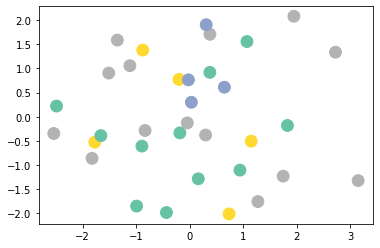

 33%|███▎      | 100/301 [00:14<00:28,  6.99it/s]

epoch=100


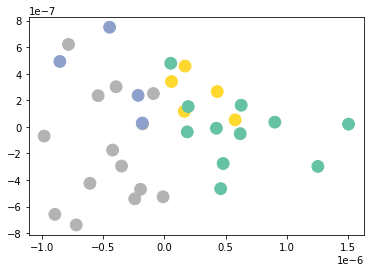

 66%|██████▋   | 200/301 [00:28<00:15,  6.47it/s]

epoch=200


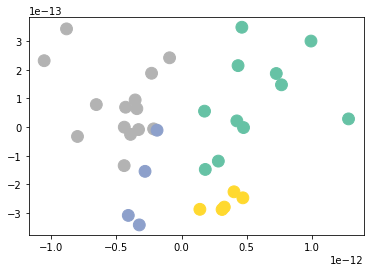

100%|█████████▉| 300/301 [00:43<00:00,  6.79it/s]

epoch=300


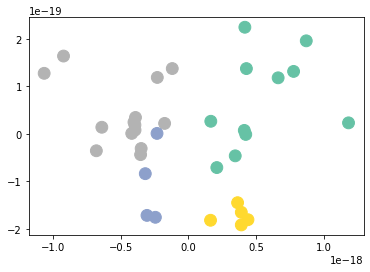

100%|██████████| 301/301 [00:44<00:00,  6.81it/s]


In [20]:
model.train_model(train_loader, 301, opt)

### K-hop neigborhood

In [21]:
class DataKhop(Dataset):
    
    def __init__(self, edge_index, k=2):
        
        Adj = to_dense_adj(data.edge_index).numpy().squeeze()
        
        Adj = (np.linalg.matrix_power(Adj, n=k) > 0) * 1.0 # A ** k
        
        pos_samples = torch.LongTensor(
            np.argwhere(Adj == 1)
        ) # positives [num_pos, 2]
        
        neg_samples = torch.LongTensor(
            np.argwhere((Adj + np.eye(len(Adj))) == 0)
        ) # negatives [num_neg, 2]
        
        label_pos = torch.ones(len(pos_samples)) # label 1 for positives
        label_neg = torch.zeros(len(neg_samples)) # label 0 for negatives
        
        print(f'num_pos={len(pos_samples)}\t num_neg={len(neg_samples)}')
        
        self.X = torch.cat([pos_samples, neg_samples]) # all samples
        self.y = torch.cat([label_pos, label_neg]) # all labels
        
    def __len__(self): return len(self.X)
    
    def __getitem__(self, idx):
        
        return self.X[idx, 0], self.X[idx, 1], self.y[idx]

In [23]:
khop = DataKhop(data.edge_index, k=2)
khop_loader = DataLoader(khop, batch_size=512, shuffle=True, num_workers=5)

num_pos=698	 num_neg=458


In [24]:
model = ShallowTrainer(data.num_nodes, 16)

opt = torch.optim.SGD(model.parameters(), lr=0.5, weight_decay=0.001)

  0%|          | 0/301 [00:00<?, ?it/s]

epoch=0


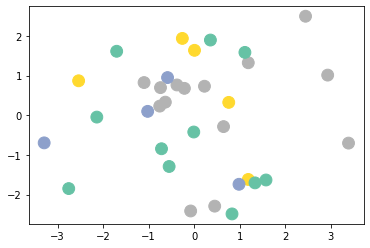

 33%|███▎      | 100/301 [00:14<00:30,  6.48it/s]

epoch=100


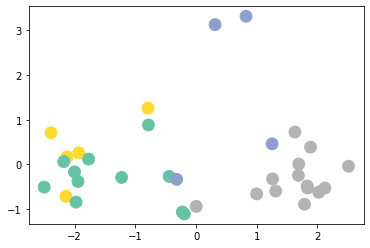

 66%|██████▋   | 200/301 [00:29<00:14,  6.81it/s]

epoch=200


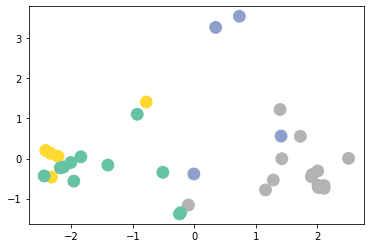

100%|█████████▉| 300/301 [00:43<00:00,  7.00it/s]

epoch=300


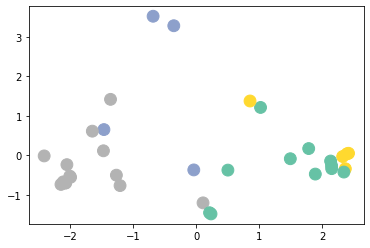

100%|██████████| 301/301 [00:43<00:00,  6.85it/s]


In [25]:
model.train_model(khop_loader, 301, opt)